In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Read and Pre-Process Data

In [0]:
%cd "/content/gdrive/My Drive/Colab Notebooks/Network Intrusion Detection System/NSL_Dataset"

/content/gdrive/My Drive/Colab Notebooks/Network Intrusion Detection System/NSL_Dataset


In [0]:
# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]


df_train_data = pd.read_csv("Train.txt", header=None, names = col_names)
df_test_data = pd.read_csv("Test.txt", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df_train_data.shape)
print('Dimensions of the Test set:',df_test_data.shape)

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


In [0]:
df_train_data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

### Creating Attack type dictionary

In [0]:
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    'worm': 'DoS',
    'mailbomb': 'DoS',
    
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'httptunnel': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

### Converting Attack into Multinomial Attack Class

In [0]:
df_train_data['attack_class'] = df_train_data['attack'].replace(attack_dict)
df_train_data['attack_class'].head(10)

0    normal
1    normal
2       DoS
3    normal
4    normal
5       DoS
6       DoS
7       DoS
8       DoS
9       DoS
Name: attack_class, dtype: object

In [0]:
df_train_data['attack_class'].unique()

array(['normal', 'DoS', 'R2L', 'Probe', 'U2R'], dtype=object)

### Converting Multinomial attack class into Binomial Int attack class

In [0]:
attack_class_binary_dict = {
    'normal': 0,
    'DoS': 1,
    'Probe': 1,
    'R2L': 1,
    'U2R': 1
}

In [0]:
df_train_data['attack_class_bin'] = df_train_data['attack_class'].replace(attack_class_binary_dict)

In [0]:
df_train_data['attack_class_bin'].unique()

array([0, 1])

### Converting Multinomial attack class into Multinomial Int attack class

In [0]:
attack_class_multi_dict = {
    'normal': 0,
    'DoS': 1,
    'Probe': 2,
    'R2L': 3,
    'U2R': 4
}

In [0]:
df_train_data['attack_class_multi'] = df_train_data['attack_class'].replace(attack_class_multi_dict)

In [0]:
df_train_data['attack_class_multi'].value_counts()

0    67343
1    45927
2    11656
3      995
4       52
Name: attack_class_multi, dtype: int64

In [0]:
df_train_data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [0]:
df_test_data['attack_class'] = df_test_data['attack'].replace(attack_dict)
df_test_data['attack_class_bin'] = df_test_data['attack_class'].replace(attack_class_binary_dict)
df_test_data['attack_class_multi'] = df_test_data['attack_class'].replace(attack_class_multi_dict)

In [0]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [0]:
df_train_data.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,attack_class,attack_class_bin,attack_class_multi
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,0,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,DoS,1,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,0,0
5,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21,DoS,1,1
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS,1,1
7,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS,1,1
8,0,tcp,remote_job,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,270,23,1.0,1.0,0.0,0.0,0.09,0.05,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS,1,1
9,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,8,1.0,1.0,0.0,0.0,0.06,0.06,0.00,255,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS,1,1


In [0]:
df_test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,attack_class,attack_class_bin,attack_class_multi
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS,1,1
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS,1,1
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,normal,0,0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,Probe,1,2
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,Probe,1,2


### Handling Categorical Data

In [0]:
cat_var_names=['protocol_type', 'service', 'flag']
print(cat_var_names)

['protocol_type', 'service', 'flag']


In [0]:
df_train_data[cat_var_names].head(10)

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF
5,tcp,private,REJ
6,tcp,private,S0
7,tcp,private,S0
8,tcp,remote_job,S0
9,tcp,private,S0


In [0]:
df_train_data_cat = df_train_data[cat_var_names]

In [0]:
df_test_data_cat=df_test_data[cat_var_names]

In [0]:
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

#### Creating Dummies variables in Train dataset

In [0]:
for c_feature in cat_var_names:
    df_train_data_cat[c_feature] = df_train_data_cat[c_feature].astype('category')
    df_train_data_cat = create_dummies(df_train_data_cat , c_feature )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
df_train_data_cat.head(10)

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,...,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### Creating Dummies variables in Test dataset

In [0]:
for c_feature in cat_var_names:
    df_test_data_cat[c_feature] = df_test_data_cat[c_feature].astype('category')
    df_test_data_cat = create_dummies(df_test_data_cat , c_feature )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Handling Numerical Data

In [0]:
# Creating list of Numerical variables (variables not in cat_var_names)
num_var_names = []
for col in df_train_data.columns:
    if col not in cat_var_names:
        num_var_names.append(col)

print(num_var_names)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'last_flag', 'attack_class', 'attack_class_bin', 'attack_class_multi']


In [0]:
df_train_data_num = df_train_data[num_var_names]

In [0]:
df_test_data_num = df_test_data[num_var_names]

### Concatenate Numerical and Categorical datasets

In [0]:
# Merging Train Numerical and Categorical datasets
df_train_merged_data = pd.DataFrame(pd.concat([df_train_data_cat, df_train_data_num ], axis=1))
df_train_merged_data.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,...,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,attack_class,attack_class_bin,attack_class_multi
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,DoS,1,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,0,0


In [0]:
# Merging Test Numerical and Categorical datasets
df_test_merged_data = pd.DataFrame(pd.concat([df_test_data_cat, df_test_data_num], axis=1))
df_test_merged_data.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,...,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,attack_class,attack_class_bin,attack_class_multi
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS,1,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,normal,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,Probe,1,2
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,Probe,1,2


In [0]:
print(df_train_merged_data.shape)
print(df_test_merged_data.shape)

(125973, 124)
(22544, 118)


Number of columns in Train dataset is more than that in Test dataset

In [0]:
train_columns=df_train_merged_data.columns.tolist()
test_columns=df_test_merged_data.columns.tolist()

In [0]:
difference=list(set(train_columns) - set(test_columns))
difference

['service_aol',
 'service_urh_i',
 'service_http_8001',
 'service_harvest',
 'service_http_2784',
 'service_red_i']

Creating missing columns in Test dataset

In [0]:
for col in difference:
    df_test_merged_data[col] = 0

In [0]:
print(df_train_merged_data.shape)
print(df_test_merged_data.shape)

(125973, 124)
(22544, 124)


# 1. Binomial Classification: Activity is normal or attack

In [0]:
df_train_merged_data.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,...,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,attack_class,attack_class_bin,attack_class_multi
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,DoS,1,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,0,0


In [0]:
df_train_data_binomial = df_train_merged_data[df_train_merged_data.columns]

In [0]:
df_train_data_binomial.drop(['attack', 'attack_class', 'attack_class_multi'],axis=1,inplace=True)

In [0]:
df_test_data_binomial = df_test_merged_data[df_test_merged_data.columns]
df_test_data_binomial.drop(['attack', 'attack_class', 'attack_class_multi'],axis=1,inplace=True)

In [0]:
df_train_data_binomial.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,...,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack_class_bin
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0


## Random Forest Feature Selection

In [0]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [0]:
forest = RandomForestClassifier(n_estimators=250,random_state=123)

In [0]:
feature_columns = df_train_data_binomial.columns.difference(['attack_class_bin'])

In [0]:
forest.fit(df_train_data_binomial[feature_columns],df_train_data_binomial['attack_class_bin'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [0]:
indices = np.argsort(forest.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(df_train_data_binomial[feature_columns].shape[1]):
  feature_rank.loc[f] = [f+1,
                         df_train_data_binomial[feature_columns].columns[indices[f]],
                         forest.feature_importances_[indices[f]]]
feature_rank

,rank,feature,importance
0,1,src_bytes,1.468958e-01
1,2,dst_bytes,1.058222e-01
2,3,flag_SF,8.030013e-02
3,4,dst_host_srv_count,5.703309e-02
4,5,same_srv_rate,5.548611e-02
...,...,...,...
115,116,service_kshell,3.133159e-09
116,117,num_outbound_cmds,0.000000e+00
117,118,service_http_2784,0.000000e+00
118,119,service_http_8001,0.000000e+00


Selecting top 25 Feature Columns from Random Forest

In [0]:
top_feature_columns = feature_rank.feature.head(25).values.tolist()
top_feature_columns

['src_bytes',
 'dst_bytes',
 'flag_SF',
 'dst_host_srv_count',
 'same_srv_rate',
 'last_flag',
 'dst_host_same_srv_rate',
 'diff_srv_rate',
 'dst_host_diff_srv_rate',
 'count',
 'dst_host_same_src_port_rate',
 'logged_in',
 'dst_host_srv_serror_rate',
 'service_http',
 'dst_host_serror_rate',
 'dst_host_srv_diff_host_rate',
 'serror_rate',
 'srv_serror_rate',
 'service_ecr_i',
 'srv_count',
 'dst_host_count',
 'dst_host_rerror_rate',
 'service_private',
 'flag_S0',
 'dst_host_srv_rerror_rate']

## Feature selection through Recursive Feature Elimination

In [0]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split( df_train_data_binomial[top_feature_columns],
                                                  df_train_data_binomial['attack_class_bin'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

In [0]:
train_X = sm.add_constant(train_X)
test_X = sm.add_constant(test_X)

In [0]:
print( len( train_X ))
print( len( test_X))

88181
37792


In [0]:
lm=sm.Logit(train_Y,train_X).fit()

while (1):
    lm=sm.Logit(train_Y,train_X).fit()
    
    df = pd.DataFrame(lm.pvalues)
    df.reset_index(inplace=True)
    df.columns = ['coeff', 'pvalue']

    max_pvalue=df['pvalue'].max()
    max_pvalue_coeff=df.loc[df['pvalue'].idxmax()]['coeff']

    if max_pvalue > 0.05:
        print("Dropping ", max_pvalue_coeff ," as its P-Value " + str(max_pvalue) + " > 5% and rebuild the model")
        train_X.drop(max_pvalue_coeff,axis=1,inplace=True)
        test_X.drop(max_pvalue_coeff,axis=1,inplace=True)
        
    else:
        break
lm.summary()

Optimization terminated successfully.
         Current function value: 0.065234
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065234
         Iterations 11
Dropping  dst_host_same_srv_rate  as its P-Value 0.8998934997694004 > 5% and rebuild the model
Optimization terminated successfully.
         Current function value: 0.065235
         Iterations 11
Dropping  dst_bytes  as its P-Value 0.5455347559382298 > 5% and rebuild the model
Optimization terminated successfully.
         Current function value: 0.065235
         Iterations 11
Dropping  dst_host_diff_srv_rate  as its P-Value 0.14435722926048108 > 5% and rebuild the model
Optimization terminated successfully.
         Current function value: 0.065247
         Iterations 11
Dropping  src_bytes  as its P-Value 0.09019075116150084 > 5% and rebuild the model
Optimization terminated successfully.
         Current function value: 0.065258
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       attack_class_bin   No. Observations:                88181
Model:                          Logit   Df Residuals:                    88159
Method:                           MLE   Df Model:                           21
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.9055
Time:                        15:07:11   Log-Likelihood:                -5754.5
converged:                       True   LL-Null:                       -60906.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          10.5152      0.305     34.510      0.000       9.918      11.112
flag_SF                         2.2984      0.194     11.821      0.000       1.917       2.680
dst_host_srv_count             -0.0059      0.000    -16.926      0.000      -0.007      -0.005
same_srv_rate                  -2.6208      0.136    -19.282      0.000      -2.887      -2.354
last_flag                      -0.8577      0.013    -63.615      0.000      -0.884      -0.831
diff_srv_rate                  -1.5865      0.171     -9.299      0.000      -1.921      -1.252
count                           0.0185      0.001     19.511      0.000       0.017       0.020
dst_host_same_src_port_rate     3.2002      0.087     36.704      0.000       3.029       3.371
logged_in                      -0.9185      0.102     -9.037      0.000      -1.118      -0.719
dst_host_srv_serror_rate        2.2255      0.243      9.146      0.000       1.749       2.702
service_http                    1.0818      0.104     10.387      0.000       0.878       1.286
dst_host_serror_rate           -0.5203      0.239     -2.179      0.029      -0.988      -0.052
dst_host_srv_diff_host_rate     7.4615      0.215     34.719      0.000       7.040       7.883
serror_rate                    -3.1658      0.382     -8.298      0.000      -3.914      -2.418
srv_serror_rate                 5.0886      0.398     12.793      0.000       4.309       5.868
service_ecr_i                   4.7418      0.127     37.251      0.000       4.492       4.991
srv_count                      -0.0144      0.001    -14.279      0.000      -0.016      -0.012
dst_host_count                  0.0058      0.000     13.814      0.000       0.005       0.007
dst_host_rerror_rate            1.4571      0.159      9.149      0.000       1.145       1.769
service_private                 3.6521      0.093     39.318      0.000       3.470       3.834
flag_S0                         5.2010      0.205     25.404      0.000       4.800       5.602
dst_host_srv_rerror_rate        3.8902      0.227     17.165      0.000       3.446       4.334
===============================================================================================
"""

In [0]:
top_feature_columns = train_X.columns
top_feature_columns

Index(['const', 'flag_SF', 'dst_host_srv_count', 'same_srv_rate', 'last_flag',
       'diff_srv_rate', 'count', 'dst_host_same_src_port_rate', 'logged_in',
       'dst_host_srv_serror_rate', 'service_http', 'dst_host_serror_rate',
       'dst_host_srv_diff_host_rate', 'serror_rate', 'srv_serror_rate',
       'service_ecr_i', 'srv_count', 'dst_host_count', 'dst_host_rerror_rate',
       'service_private', 'flag_S0', 'dst_host_srv_rerror_rate'],
      dtype='object')

## Explore different classification models and determine the best model for the prediction

### Binary Logistic Regression Model

In [0]:
logit = sm.Logit(train_Y,train_X)
logit_model = logit.fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.065258
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       attack_class_bin   No. Observations:                88181
Model:                          Logit   Df Residuals:                    88159
Method:                           MLE   Df Model:                           21
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.9055
Time:                        15:07:23   Log-Likelihood:                -5754.5
converged:                       True   LL-Null:                       -60906.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          10.5152      0.305     34.510      0.000       9.918      11.112
flag_SF                         2.2984      0.194     11.821      0.000       1.917       2.680
dst_host_srv_count             -0.0059      0.000    -16.926      0.000      -0.007      -0.005
same_srv_rate                  -2.6208      0.136    -19.282      0.000      -2.887      -2.354
last_flag                      -0.8577      0.013    -63.615      0.000      -0.884      -0.831
diff_srv_rate                  -1.5865      0.171     -9.299      0.000      -1.921      -1.252
count                           0.0185      0.001     19.511      0.000       0.017       0.020
dst_host_same_src_port_rate     3.2002      0.087     36.704      0.000       3.029       3.371
logged_in                      -0.9185      0.102     -9.037      0.000      -1.118      -0.719
dst_host_srv_serror_rate        2.2255      0.243      9.146      0.000       1.749       2.702
service_http                    1.0818      0.104     10.387      0.000       0.878       1.286
dst_host_serror_rate           -0.5203      0.239     -2.179      0.029      -0.988      -0.052
dst_host_srv_diff_host_rate     7.4615      0.215     34.719      0.000       7.040       7.883
serror_rate                    -3.1658      0.382     -8.298      0.000      -3.914      -2.418
srv_serror_rate                 5.0886      0.398     12.793      0.000       4.309       5.868
service_ecr_i                   4.7418      0.127     37.251      0.000       4.492       4.991
srv_count                      -0.0144      0.001    -14.279      0.000      -0.016      -0.012
dst_host_count                  0.0058      0.000     13.814      0.000       0.005       0.007
dst_host_rerror_rate            1.4571      0.159      9.149      0.000       1.145       1.769
service_private                 3.6521      0.093     39.318      0.000       3.470       3.834
flag_S0                         5.2010      0.205     25.404      0.000       4.800       5.602
dst_host_srv_rerror_rate        3.8902      0.227     17.165      0.000       3.446       4.334
===============================================================================================
"""

#### Finding Gini Index for Logistic Regression Model

In [0]:
from sklearn import metrics

In [0]:
log_reg_train_gini = 2*metrics.roc_auc_score(train_Y, logit_model.predict(train_X)) - 1
print("The Gini Index for the Logistic Regression model built on the Train Data is : ", log_reg_train_gini)

The Gini Index for the Logistic Regression model built on the Train Data is :  0.9928497359158115


In [0]:
log_reg_test_gini = 2*metrics.roc_auc_score(test_Y, logit_model.predict(test_X)) - 1
print("The Gini Index for the Logistic Regression model built on the Test Data is : ", log_reg_test_gini)

The Gini Index for the Logistic Regression model built on the Test Data is :  0.9926807774778126


In [0]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(logit_model.predict(test_X[top_feature_columns]))
test_predicted_prob.columns = ['prob']
test_actual = test_Y
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head(10)

,actual,prob
85247,0,0.000225
121265,1,0.997252
99209,1,0.943514
8177,1,0.999460
90461,0,0.021365
42306,1,0.995312
32788,1,0.870378
84162,0,0.000209
74618,1,0.991767
4720,0,0.000472


#### Finding Cut-off Probability to Predict 0 or 1

In [0]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
test_temp = test_predict.copy()

for cut_off in np.linspace(0,1,50):
    test_temp['cut_off'] = cut_off
    test_temp['predicted'] = test_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    test_temp['tp'] = test_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    test_temp['fp'] = test_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    test_temp['tn'] = test_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    test_temp['fn'] = test_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = test_temp['tp'].sum() / (test_temp['tp'].sum() + test_temp['fn'].sum())
    specificity = test_temp['tn'].sum() / (test_temp['tn'].sum() + test_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [0]:
roc_like_df

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,0.999546,0.876302
0,0.040816,0.997958,0.914195
0,0.061224,0.997050,0.930215
0,0.081633,0.996653,0.939689
0,0.102041,0.995349,0.943508
0,0.122449,0.995292,0.947327
0,0.142857,0.994895,0.949856
0,0.163265,0.994101,0.951543
0,0.183673,0.993931,0.953824


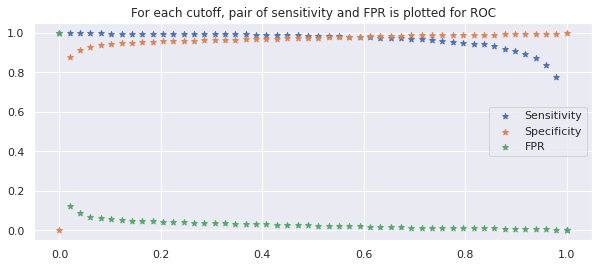

In [0]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [0]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.469388,0.986727,0.973366,1.960093


Sensitivity and Specificity are maximum at ~ 0.47 Probability cutoff 

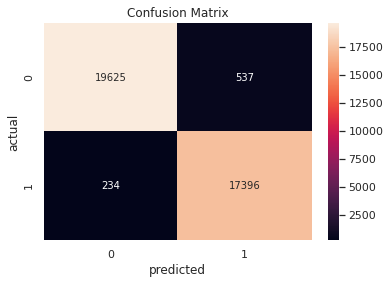

In [0]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.47 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

In [0]:
log_reg_accuracy_score = metrics.accuracy_score(test_predict.actual, test_predict.predicted)
print("The overall accuracy score for the Logistic Regression Test Data is : ",log_reg_accuracy_score)
#print("The overall accuracy score for the Validation Data  is : ", metrics.accuracy_score(df_test_new.attack_class_bin, df_test_new.predicted))

The overall accuracy score for the Logistic Regression Test Data is :  0.9795988569009314


### Decision Tree Classifier Model

In [0]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
top_feature_columns

Index(['const', 'flag_SF', 'dst_host_srv_count', 'same_srv_rate', 'last_flag',
       'diff_srv_rate', 'count', 'dst_host_same_src_port_rate', 'logged_in',
       'dst_host_srv_serror_rate', 'service_http', 'dst_host_serror_rate',
       'dst_host_srv_diff_host_rate', 'serror_rate', 'srv_serror_rate',
       'service_ecr_i', 'srv_count', 'dst_host_count', 'dst_host_rerror_rate',
       'service_private', 'flag_S0', 'dst_host_srv_rerror_rate'],
      dtype='object')

In [0]:
train_X.drop('const', inplace=True, axis=1)
test_X.drop('const', inplace=True, axis=1)

In [0]:
top_feature_columns = train_X.columns
top_feature_columns

Index(['flag_SF', 'dst_host_srv_count', 'same_srv_rate', 'last_flag',
       'diff_srv_rate', 'count', 'dst_host_same_src_port_rate', 'logged_in',
       'dst_host_srv_serror_rate', 'service_http', 'dst_host_serror_rate',
       'dst_host_srv_diff_host_rate', 'serror_rate', 'srv_serror_rate',
       'service_ecr_i', 'srv_count', 'dst_host_count', 'dst_host_rerror_rate',
       'service_private', 'flag_S0', 'dst_host_srv_rerror_rate'],
      dtype='object')

#### Fine Tuning Parameters

In [0]:
param_grid = {'max_depth': np.arange(3, 8),
             'max_features': np.arange(3,top_feature_columns.size)}

In [0]:
tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv = 10, n_jobs=-1)
tree_gs.fit( train_X, train_Y )

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=123,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                  

In [0]:
tree_gs.best_params_

{'max_depth': 7, 'max_features': 20}

#### Building Final Decision Tree Model

In [0]:
clf_tree = DecisionTreeClassifier( max_depth = 7, max_features=20, random_state=123 )
clf_tree.fit( train_X, train_Y )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [0]:
tree_test_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': clf_tree.predict( test_X ) } )

In [0]:
tree_test_pred.sample( n = 10 )

,actual,predicted
26317,0,0
114907,0,0
125531,0,0
45009,1,1
58270,0,0
28133,0,0
3749,1,1
122179,1,1
99299,1,1
21250,0,0


In [0]:
tree_accuracy_score = metrics.accuracy_score(tree_test_pred.actual, tree_test_pred.predicted)
print("The overall accuracy score for the Decision Tree Test Data is : ",tree_accuracy_score)

The overall accuracy score for the Decision Tree Test Data is :  0.9939669771380186


#### Confusion Matrix for Decision Tree

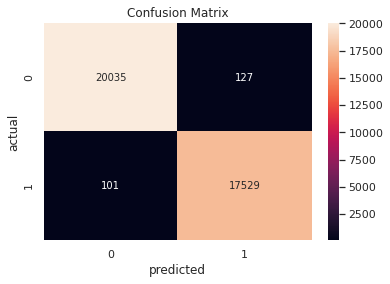

In [0]:
sns.heatmap(pd.crosstab(tree_test_pred['actual'], tree_test_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

### Bagging Classifier Model

In [0]:
from sklearn.ensemble import BaggingClassifier

#### Fine Tuning Parameters

In [0]:
param_grid = {'max_features': np.arange(3,top_feature_columns.size)}

In [0]:
bag_classifier_gs = GridSearchCV(BaggingClassifier(random_state=123), param_grid, cv = 10)
bag_classifier_gs.fit( train_X, train_Y )

GridSearchCV(cv=10, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=123,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_features': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
bag_classifier_gs.best_params_

{'max_features': 18}

#### Building Final Bagging Model

In [0]:
bag_classifier = BaggingClassifier(oob_score=True, n_estimators=100, max_features=18, random_state=123)
bag_classifier.fit(train_X, train_Y)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=18, max_samples=1.0, n_estimators=100,
                  n_jobs=None, oob_score=True, random_state=123, verbose=0,
                  warm_start=False)

In [0]:
bagging_test_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': bag_classifier.predict( test_X ) } )

In [0]:
bagging_test_pred.sample( n = 10 )

,actual,predicted
100054,0,0
86582,1,1
35410,1,1
43603,0,0
107629,1,1
36009,0,0
50582,0,0
83956,1,1
61063,1,1
5527,1,1


In [0]:
bagging_accuracy_score = metrics.accuracy_score(bagging_test_pred.actual, bagging_test_pred.predicted)
print("The overall accuracy score for the Bagging Test Data is : ",bagging_accuracy_score)

The overall accuracy score for the Bagging Test Data is :  0.9986769686706182


#### Confusion Matrix for Bagging Classifier Model

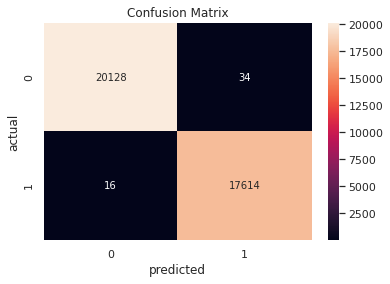

In [0]:
sns.heatmap(pd.crosstab(bagging_test_pred['actual'], bagging_test_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

In [0]:
bag_classifier.oob_score_

0.9987525657454553

### Random Forest Classifier Model

In [0]:
from sklearn.ensemble import RandomForestClassifier

#### Fine Tuning Parameters

In [0]:
param_grid = {'max_depth': np.arange(3, 8) 
              , 'max_features': np.arange(3,top_feature_columns.size)
              , 'min_samples_split': np.arange(30,40) }

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [0]:
# May take hours to execute
rf_gs = GridSearchCV(RandomForestClassifier(oob_score=True,n_estimators=10, n_jobs=-1 ), 
                        param_grid, 
                        cv=10)
rf_gs.fit(train_X, train_Y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                   

In [0]:
rf_gs.best_params_

{'max_depth': 7, 'max_features': 9, 'min_samples_split': 30}

#### Building Final Random Forest Classifier Model

In [0]:
radm_clf = RandomForestClassifier(oob_score=True, n_estimators=100, max_depth = 7, max_features = 9, min_samples_split = 30, random_state=123)
radm_clf.fit( train_X, train_Y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123, verbose=0,
                       warm_start=False)

In [0]:
radm_test_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': radm_clf.predict( test_X ) } )

In [0]:
radm_test_pred.sample( n = 10 )

,actual,predicted
112964,0,0
89192,1,1
80434,1,1
95917,0,0
27303,0,0
95043,0,0
91034,1,1
26800,1,1
50446,0,0
49328,1,1


In [0]:
random_forest_accuracy_score = metrics.accuracy_score(radm_test_pred.actual, radm_test_pred.predicted)
print("The overall accuracy score for the Random Forest Test Data is : ",random_forest_accuracy_score)

The overall accuracy score for the Random Forest Test Data is :  0.9958986028789162


#### Confusion Matrix for Random Forest Classifier Model

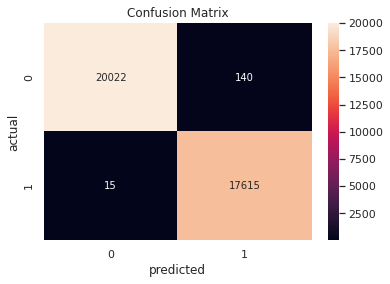

In [0]:
sns.heatmap(pd.crosstab(radm_test_pred['actual'], radm_test_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

In [0]:
radm_clf.oob_score_

0.9959968700740522

### Naive Bayes Classifier

In [0]:
from sklearn.naive_bayes import GaussianNB

#### Building Naive Bayes Classification Model

In [0]:
naive_bayes_bin = GaussianNB()

In [0]:
naive_bayes_bin.fit(train_X, train_Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
naive_bayes_bin_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': naive_bayes_bin.predict( test_X ) } )

In [0]:
naive_bayes_bin_pred.sample( n = 10 )

,actual,predicted
2383,1,1
51441,1,1
102765,1,1
45846,1,1
22216,0,0
108807,0,0
48231,0,0
62291,0,0
53040,0,0
118847,0,0


In [0]:
naive_bayes_bin_accuracy_score = metrics.accuracy_score(naive_bayes_bin_pred.actual, naive_bayes_bin_pred.predicted)
print("Binomial Naive Bayes Classification Accuracy Score : ",naive_bayes_bin_accuracy_score)

Binomial Naive Bayes Classification Accuracy Score :  0.9420776883996613


#### Confusion Matrix for Naive Bayes Classification

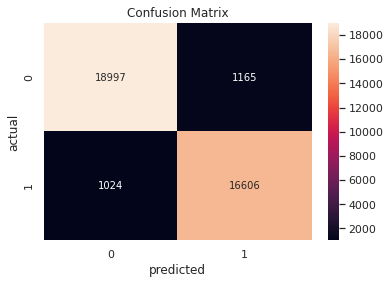

In [0]:
sns.heatmap(pd.crosstab(naive_bayes_bin_pred['actual'], naive_bayes_bin_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

### KNN (K-Nearest Neighbours) Classifier

In [0]:
from sklearn import datasets 
from sklearn.neighbors import KNeighborsClassifier

#### Fine Tuning Parameters

In [0]:
param_grid = {'n_neighbors': np.arange(2, 8)}

In [0]:
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 10, n_jobs=-1)
knn_gs.fit( train_X, train_Y )

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6, 7])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
knn_gs.best_params_

{'n_neighbors': 3}

In [0]:
knn_clf = KNeighborsClassifier(n_neighbors = 3)

In [0]:
knn_clf.fit(train_X, train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
knn_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': knn_clf.predict( test_X ) } )

In [0]:
knn_pred.sample( n = 10 )

,actual,predicted
34082,0,0
69173,0,0
73152,0,0
16549,0,0
91970,1,1
93865,1,1
118055,0,0
75910,1,1
125320,1,1
42941,0,0


In [0]:
knn_accuracy_score = metrics.accuracy_score(knn_pred.actual, knn_pred.predicted)
print("KNN Classification Accuracy Score : ",knn_accuracy_score)

KNN Classification Accuracy Score :  0.9905270956816258


## Comparing scores of different Classification models and determining the best model for the prediction

In [0]:
print("Logistic Regression Model  = " + str(log_reg_accuracy_score))
print("Decision Tree Classifier Model Score = " + str(tree_accuracy_score))
print("Bagging Classifier Model Score= " + str(bagging_accuracy_score))
print("Random Forest Classifier Model Score = " + str(random_forest_accuracy_score))
print("Naive Bayes Classification Model Score = : " + str(naive_bayes_bin_accuracy_score))
print("KNN Classification Model Score : " + str(knn_accuracy_score))

Logistic Regression Model  = 0.9795988569009314
Decision Tree Classifier Model Score = 0.9939669771380186
Bagging Classifier Model Score= 0.9986769686706182
Random Forest Classifier Model Score = 0.9958986028789162
Naive Bayes Classification Model Score = : 0.9420776883996613
KNN Classification Model Score : 0.9905270956816258


All of the classification Models have accuracy score > 94%.
Bagging classifier model has the highest accuracy score of 99.87%


## Using Bagging Classifier model to predict for Test dataset

In [0]:
X = df_test_data_binomial[top_feature_columns]
Y = df_test_data_binomial['attack_class_bin']

In [0]:
bin_test_pred = pd.DataFrame( { 'actual':  Y,
                            'predicted': bag_classifier.predict( X ) } )

In [0]:
bin_test_pred.sample( n = 10 )

,actual,predicted
6587,1,0
12836,0,0
16054,1,1
5333,0,1
17915,1,0
17133,0,0
18604,1,1
18404,0,1
4823,1,1
12878,0,0


In [0]:
bin_accuracy_score = metrics.accuracy_score(bin_test_pred.actual, bin_test_pred.predicted)
print("The overall accuracy score for Binomial prediction on the Test Dataset is : ", bin_accuracy_score)

The overall accuracy score for Binomial prediction on the Test Dataset is :  0.8957150461320085


#### Confusion Matrix for the Binomial Classification Model

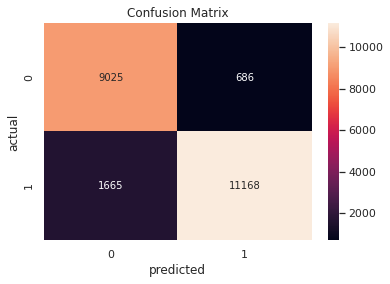

In [0]:
sns.heatmap(pd.crosstab(bin_test_pred['actual'], bin_test_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

# 2. Multinomial Classification: Activity is normal or DOS or PROBE or R2L or U2R 

In [0]:
df_train_merged_data.columns

Index(['protocol_type_tcp', 'protocol_type_udp', 'service_X11',
       'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp',
       'service_courier', 'service_csnet_ns', 'service_ctf',
       ...
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack', 'last_flag', 'attack_class',
       'attack_class_bin', 'attack_class_multi'],
      dtype='object', length=124)

In [0]:
df_train_data_multinomial = df_train_merged_data[df_train_merged_data.columns]

In [0]:
df_train_data_multinomial.drop(['attack', 'attack_class_bin'],axis=1,inplace=True)

In [0]:
df_test_data_multinomial = df_test_merged_data[df_test_merged_data.columns]
df_test_data_multinomial.drop(['attack', 'attack_class_bin'],axis=1,inplace=True)

In [0]:
df_test_data_multinomial.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,...,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack_class,attack_class_multi,service_aol,service_urh_i,service_http_8001,service_harvest,service_http_2784,service_red_i
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21,DoS,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21,DoS,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,21,normal,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,15,Probe,2,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,11,Probe,2,0,0,0,0,0,0


In [0]:
df_train_data_multinomial['attack_class_multi'].value_counts()

0    67343
1    45927
2    11656
3      995
4       52
Name: attack_class_multi, dtype: int64

In [0]:
df_train_data_multinomial.drop('attack_class',axis=1,inplace=True)

In [0]:
df_test_data_multinomial.drop('attack_class',axis=1,inplace=True)

In [0]:
df_test_data_multinomial['attack_class_multi'].value_counts()

0    9711
1    7460
3    2885
2    2421
4      67
Name: attack_class_multi, dtype: int64

## Random Forest Feature Selection

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
forest_multi = RandomForestClassifier(n_estimators=250,random_state=123)

In [0]:
feature_columns = df_train_data_multinomial.columns.difference(['attack_class_multi'])

In [0]:
forest_multi.fit(df_train_data_multinomial[feature_columns],df_train_data_multinomial['attack_class_multi'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [0]:
indices = np.argsort(forest_multi.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(df_train_data_multinomial[feature_columns].shape[1]):
  feature_rank.loc[f] = [f+1,
                         df_train_data_multinomial[feature_columns].columns[indices[f]],
                         forest_multi.feature_importances_[indices[f]]]
feature_rank

,rank,feature,importance
0,1,src_bytes,1.231843e-01
1,2,same_srv_rate,6.909034e-02
2,3,dst_bytes,6.845032e-02
3,4,flag_SF,5.814492e-02
4,5,diff_srv_rate,5.571271e-02
...,...,...,...
115,116,service_aol,4.839686e-07
116,117,service_harvest,2.177654e-07
117,118,service_http_2784,0.000000e+00
118,119,is_host_login,0.000000e+00


Selecting top 25 Feature Columns from Random Forest

In [0]:
top_feature_columns = feature_rank.feature.head(25).values.tolist()
top_feature_columns

['src_bytes',
 'same_srv_rate',
 'dst_bytes',
 'flag_SF',
 'diff_srv_rate',
 'count',
 'dst_host_serror_rate',
 'dst_host_same_srv_rate',
 'dst_host_srv_count',
 'last_flag',
 'dst_host_srv_serror_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'serror_rate',
 'flag_S0',
 'srv_count',
 'srv_serror_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'service_ecr_i',
 'dst_host_count',
 'service_http',
 'service_eco_i',
 'logged_in',
 'protocol_type_tcp']

## Explore different classification models and determine the best model for the prediction

Split into Train and Test datasets

In [0]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split( df_train_data_multinomial[top_feature_columns],
                                                  df_train_data_multinomial['attack_class_multi'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

In [0]:
train_X = sm.add_constant(train_X)
test_X = sm.add_constant(test_X)

Normalizing datasets

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
# Apply transform to both the training set and the test set.
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

### Multinomial Logistic Regression Model

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
lr_multinomial = LogisticRegression(multi_class='multinomial',solver='newton-cg')

In [0]:
lr_multinomial_model = lr_multinomial.fit(train_X_scaled, train_Y)

In [0]:
lr_mult_accuracy_score = metrics.accuracy_score(test_Y, lr_multinomial_model.predict(test_X_scaled))
print("Multinomial Logistic regression Test Accuracy :: ", lr_mult_accuracy_score)

Multinomial Logistic regression Test Accuracy ::  0.9742802709568162


In [0]:
lr_multi_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': lr_multinomial_model.predict( test_X_scaled ) } )

#### Confusion Matrix for Multinomial Logistic Regression Model

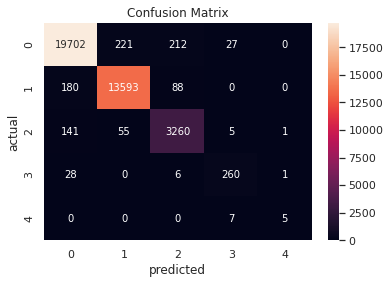

In [0]:
sns.heatmap(pd.crosstab(lr_multi_pred['actual'], lr_multi_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

### Desision Tree Classifier Model

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
train_X.drop('const', inplace=True, axis=1)
test_X.drop('const', inplace=True, axis=1)

In [0]:
feature_columns = train_X.columns
feature_columns

Index(['src_bytes', 'same_srv_rate', 'dst_bytes', 'flag_SF', 'diff_srv_rate',
       'count', 'dst_host_serror_rate', 'dst_host_same_srv_rate',
       'dst_host_srv_count', 'last_flag', 'dst_host_srv_serror_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'serror_rate',
       'flag_S0', 'srv_count', 'srv_serror_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'service_ecr_i',
       'dst_host_count', 'service_http', 'service_eco_i', 'logged_in',
       'protocol_type_tcp'],
      dtype='object')

#### Fine Tuning Parameters

In [0]:
param_grid = {'max_depth': np.arange(3, 8),
             'max_features': np.arange(3,feature_columns.size)}

In [0]:
tree_multi_gs = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv = 10, n_jobs=-1)
tree_multi_gs.fit( train_X, train_Y )

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=123,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                  

In [0]:
tree_multi_gs.best_params_

{'max_depth': 7, 'max_features': 12}

#### Building Final Decision Tree Model

In [0]:
tree_multi = DecisionTreeClassifier( max_depth = 7, max_features=12, random_state=123 )
tree_multi.fit( train_X, train_Y )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=12, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [0]:
tree_multi_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': tree_multi.predict( test_X ) } )

In [0]:
tree_multi_pred.sample( n = 10 )

,actual,predicted
43959,0,0
5556,0,0
85512,1,1
72124,1,1
79967,2,2
67052,1,1
84680,0,0
106220,0,0
104847,0,0
46980,2,2


In [0]:
multi_tree_accuracy_score = metrics.accuracy_score(tree_multi_pred.actual, tree_multi_pred.predicted)
print("Multinomial Decision Tree Classification Accuracy Score : ",multi_tree_accuracy_score)

Multinomial Decision Tree Classification Accuracy Score :  0.9930408552074513


#### Confusion Matrix for Decision Tree

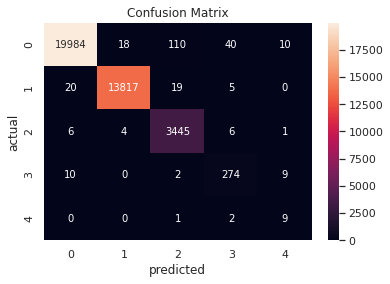

In [0]:
sns.heatmap(pd.crosstab(tree_multi_pred['actual'], tree_multi_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

### KNN (K-Nearest Neighbours) Classifier

In [0]:
from sklearn import datasets 
from sklearn.neighbors import KNeighborsClassifier

#### Fine Tuning Parameters

In [0]:
param_grid = {'n_neighbors': np.arange(1, 8)}

In [0]:
knn_multi_gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 10, n_jobs=-1)
knn_multi_gs.fit( train_X, train_Y )

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
knn_multi_gs.best_params_

{'n_neighbors': 1}

#### Building Final KNN Classification Model

In [0]:
knn_multi = KNeighborsClassifier(n_neighbors = 1)

In [0]:
knn_multi.fit(train_X, train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
knn_multi_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': knn_multi.predict( test_X ) } )

In [0]:
knn_multi_pred.sample( n = 10 )

,actual,predicted
36647,0,0
90737,0,0
47824,0,0
49846,0,0
94495,0,0
52693,0,0
65457,2,2
70875,0,0
109255,1,1
15365,0,0


In [0]:
knn_multi_accuracy_score = metrics.accuracy_score(knn_multi_pred.actual, knn_multi_pred.predicted)
print("Multinomial KNN Classification Accuracy Score : ",knn_multi_accuracy_score)

Multinomial KNN Classification Accuracy Score :  0.994522650296359


#### Confusion Matrix for KNN Classification

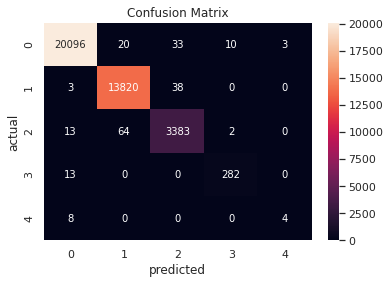

In [0]:
sns.heatmap(pd.crosstab(knn_multi_pred['actual'], knn_multi_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

### Naive Bayes Classifier

In [0]:
from sklearn.naive_bayes import GaussianNB 

#### Building Naive Bayes Classification Model

In [0]:
naive_bayes_multi = GaussianNB()

In [0]:
naive_bayes_multi.fit(train_X_scaled, train_Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
naive_bayes_multi_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': naive_bayes_multi.predict( test_X_scaled ) } )

In [0]:
naive_bayes_multi_pred.sample( n = 10 )

,actual,predicted
91935,0,0
66984,0,4
36274,0,0
98923,0,0
89870,0,0
4128,1,1
45994,0,0
97140,0,4
103536,2,4
56658,0,4


In [0]:
naive_bayes_multi_accuracy_score = metrics.accuracy_score(naive_bayes_multi_pred.actual, naive_bayes_multi_pred.predicted)
print("Multinomial Naive Bayes Classification Accuracy Score : ",naive_bayes_multi_accuracy_score)

Multinomial Naive Bayes Classification Accuracy Score :  0.7893469517358171


#### Confusion Matrix for Naive Bayes Classification

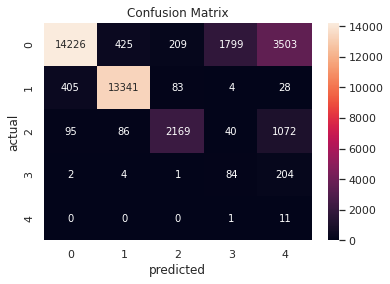

In [0]:
sns.heatmap(pd.crosstab(naive_bayes_multi_pred['actual'], naive_bayes_multi_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

### Random Forest Classifier Model

In [0]:
from sklearn.ensemble import RandomForestClassifier

#### Fine Tuning Parameters

In [0]:
param_grid = {'max_depth': np.arange(3, 8)
              , 'max_features': np.arange(3,feature_columns.size)
              , 'min_samples_split': np.arange(30,40) }

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [0]:
# May take hours to execute
rf_multi_gs = GridSearchCV(RandomForestClassifier(oob_score=True,n_estimators=10, n_jobs=-1, random_state=123 ), 
                        param_grid,
                        cv=10)
rf_multi_gs.fit(train_X, train_Y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oo...e=True, random_state=123,
                                       

In [0]:
rf_multi_gs.best_params_

{'max_depth': 7, 'max_features': 15, 'min_samples_split': 33}

#### Building Final Random Forest Classifier Model

In [0]:
rf_multi = RandomForestClassifier(oob_score=True, n_estimators=100, max_depth = 7, max_features = 15, min_samples_split = 33
                                  , random_state=123)
rf_multi.fit( train_X, train_Y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=33,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123, verbose=0,
                       warm_start=False)

In [0]:
multi_radm_test_pred = pd.DataFrame( { 'actual':  test_Y,
                            'predicted': rf_multi.predict( test_X ) } )

In [0]:
multi_radm_test_pred.sample( n = 10 )

,actual,predicted
84578,1,1
93942,1,1
62448,0,0
92726,0,0
53598,0,0
47347,0,0
65354,0,0
39022,1,1
26009,2,2
64310,0,0


In [0]:
rf_multi_accuracy_score = metrics.accuracy_score(multi_radm_test_pred.actual, multi_radm_test_pred.predicted)
print("Multinomial Random Forest Classification Accuracy Score : ",rf_multi_accuracy_score)

Multinomial Random Forest Classification Accuracy Score :  0.9962161303979679


#### Confusion Matrix for Multinomial Random Forest Classifier Model

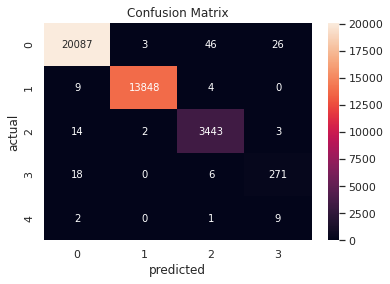

In [0]:
sns.heatmap(pd.crosstab(multi_radm_test_pred['actual'], multi_radm_test_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

In [0]:
rf_multi.oob_score_

0.9961896553679364

## Comparing scores of different Multinomial Classification models and determining the best model for the prediction

In [0]:
print("Multinomal Logistic Regression Model  = ", lr_mult_accuracy_score)
print("Multinomial Decision Tree Classification Model : ",multi_tree_accuracy_score)
print("Multinomial KNN Classification Model : ",knn_multi_accuracy_score)
print("Multinomial Naive Bayes Classification Model : ",naive_bayes_multi_accuracy_score)
print("Multinomial Random Forest Classification Model : ",rf_multi_accuracy_score)

Multinomal Logistic Regression Model  =  0.9742802709568162
Multinomial Decision Tree Classification Model :  0.9930408552074513
Multinomial KNN Classification Model :  0.994522650296359
Multinomial Naive Bayes Classification Model :  0.7893469517358171
Multinomial Random Forest Classification Model :  0.9962161303979679


Naive Bayes Model has accuracy score ~78%.
Logistic Regression model has accurace score ~ 97%.
Decision Tree, KNN and Random Forest models have accuracy score > 99%.



Confusion matrix of Decision Tree, KNN and Random Forest models show that Decision Tree model is the best predictor of Attack Class = 4.

## Using Decision Tree model to Predict for Test Dataset 

In [0]:
X = df_test_data_multinomial[feature_columns]
Y = df_test_data_multinomial['attack_class_multi']

In [0]:
multi_test_pred = pd.DataFrame( { 'actual':  Y,
                            'predicted': tree_multi.predict( X ) } )

In [0]:
multi_test_pred.sample( n = 10 )

,actual,predicted
13669,0,0
12496,1,1
3824,1,1
10192,0,0
9110,3,0
19206,0,0
8827,0,0
115,1,1
18784,2,2
8880,1,1


In [0]:
multi_accuracy_score = metrics.accuracy_score(multi_test_pred.actual, multi_test_pred.predicted)
print("The overall accuracy score for Multinomial prediction on the Test Dataset is : ", multi_accuracy_score)

The overall accuracy score for Multinomial prediction on the Test Dataset is :  0.8079755145493258


#### Confusion Matrix for the Multinomial Classification Model

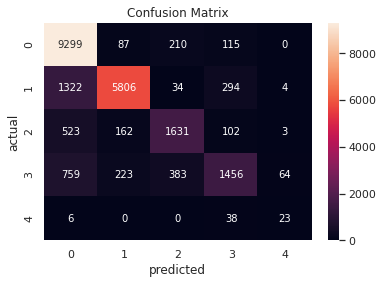

In [0]:
sns.heatmap(pd.crosstab(multi_test_pred['actual'], multi_test_pred['predicted']), annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.show()

# Adding Predicted Binary and Multinomial Attack Types in Test Dataset for Submission

In [0]:
df_test_data.drop(['predicted_attack_class_bin_int', 'predicted_attack_class_multi_int', 'predicted_attack_class_multi', 'predicted_attack_class_bin'], axis=1, inplace=True)

In [0]:
df_test_data['predicted_attack_class_bin_int'] = bin_test_pred['predicted']

In [0]:
pred_attack_class_binary_dict = {
    0: 'normal',
    1: 'Attack'
}

In [0]:
df_test_data['predicted_attack_class_bin'] = df_test_data['predicted_attack_class_bin_int'].replace(pred_attack_class_binary_dict)

In [0]:
df_test_data['predicted_attack_class_multi_int'] = multi_test_pred['predicted']

In [0]:
pred_attack_class_multi_dict = {
    0: 'normal',
    1: 'DoS',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R'
}

In [0]:
df_test_data['predicted_attack_class_multi'] = df_test_data['predicted_attack_class_multi_int'].replace(pred_attack_class_multi_dict)

In [0]:
df_test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,attack_class,attack_class_bin,attack_class_multi,predicted_attack_class_bin_int,predicted_attack_class_bin,predicted_attack_class_multi_int,predicted_attack_class_multi
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS,1,1,1,Attack,1,DoS
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS,1,1,1,Attack,1,DoS
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,normal,0,0,0,normal,0,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,Probe,1,2,1,Attack,2,Probe
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,Probe,1,2,1,Attack,3,R2L


In [0]:
df_test_data.to_excel("Test_Predict.xlsx")